In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Load the original CSV file
data_df = pd.read_csv("C:\\Users\\sangeetha\\rrg\\Data_Entry_2017.csv")

# Define the image folder path
images_folder = "C:\\Users\\sangeetha\\rrg\\images"



In [10]:
# Map each condition to a separate column with binary values
conditions = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
              'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 
              'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Add 'Image' and 'PatientId' columns
data_df['Image'] = data_df['Image Index'].apply(lambda x: os.path.join(images_folder, x))
data_df['PatientId'] = data_df['Patient ID']


In [11]:
# Initialize condition columns with 0s
for condition in conditions:
    data_df[condition] = 0

# Update condition columns to 1 where the condition is present
for index, row in data_df.iterrows():
    findings = row['Finding Labels'].split('|')  # Assumes labels are '|' separated
    for finding in findings:
        if finding in conditions:
            data_df.at[index, finding] = 1

# Select the columns in the desired order
final_df = data_df[['Image'] + conditions + ['PatientId']]

In [12]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(final_df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save each DataFrame to a CSV file
train_df.to_csv("C:\\Users\\sangeetha\\rrg\\train.csv", index=False)
valid_df.to_csv("C:\\Users\\sangeetha\\rrg\\valid.csv", index=False)
test_df.to_csv("C:\\Users\\sangeetha\\rrg\\test1.csv", index=False)

print("Train, validation, and test CSV files created with specified columns!")


Train, validation, and test CSV files created with specified columns!


In [13]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
#import cv2
import sklearn
#import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

In [14]:
# Read csv file containing training datadata
train_df = pd.read_csv("C:\\Users\\sangeetha\\rrg\\train.csv")
valid_df = pd.read_csv("C:\\Users\\sangeetha\\rrg\\valid.csv")
test_df = pd.read_csv("C:\\Users\\sangeetha\\rrg\\test1.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 78484 rows and 16 columns in the train data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,PatientId
0,C:\Users\sangeetha\rrg\images\00020185_004.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20185
1,C:\Users\sangeetha\rrg\images\00001689_009.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1689
2,C:\Users\sangeetha\rrg\images\00019519_001.png,0,0,0,0,0,0,0,0,1,1,1,0,0,0,19519
3,C:\Users\sangeetha\rrg\images\00005832_020.png,1,0,0,0,1,0,0,0,0,0,0,0,0,0,5832
4,C:\Users\sangeetha\rrg\images\00001684_026.png,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1684


In [15]:
print(f"Train set: The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")
print(f"Validation set: The total patient ids are {valid_df['PatientId'].count()}")
print(f"Test set: The total patient ids are {test_df['PatientId'].count()}")

Train set: The total patient ids are 78484, from those the unique ids are 25187 
Validation set: The total patient ids are 16818
Test set: The total patient ids are 16818


In [16]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [17]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: True
leakage between valid and test: True


In [18]:
from sklearn.model_selection import train_test_split

# Load the original CSV file
df = pd.read_csv("C:\\Users\\sangeetha\\rrg\\Data_Entry_2017.csv")

# Define the image folder path
images_folder = "C:\\Users\\sangeetha\\rrg\\images"


# Create binary columns for conditions
conditions = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

for condition in conditions:
    df[condition] = df['Finding Labels'].apply(lambda x: 1 if condition in x else 0)

# Select necessary columns
df = df[['Image Index', 'Patient ID'] + conditions]
df.rename(columns={'Image Index': 'Image', 'Patient ID': 'PatientId'}, inplace=True)

# Group by PatientId to ensure all records for a patient go to the same set
grouped_df = df.groupby('PatientId')

# Get unique patient IDs and split them
unique_patients = df['PatientId'].unique()
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)
valid_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Create train, valid, and test DataFrames based on patient splits
train_df = df[df['PatientId'].isin(train_patients)]
valid_df = df[df['PatientId'].isin(valid_patients)]
test_df = df[df['PatientId'].isin(test_patients)]

# Check for leakage to confirm the separation
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))


print("Train, validation, and test CSV files created successfully without leakage.")


leakage between train and test: False
leakage between valid and test: False
Train, validation, and test CSV files created successfully without leakage.


In [19]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'PatientId', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [20]:
# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 8175 samples
The class Cardiomegaly has 1888 samples
The class Consolidation has 3228 samples
The class Edema has 1630 samples
The class Effusion has 9433 samples
The class Emphysema has 1666 samples
The class Fibrosis has 1156 samples
The class Hernia has 158 samples
The class Infiltration has 13849 samples
The class Mass has 4239 samples
The class Nodule has 4425 samples
The class Pleural_Thickening has 2379 samples
The class Pneumonia has 936 samples
The class Pneumothorax has 3768 samples


Display Random Images


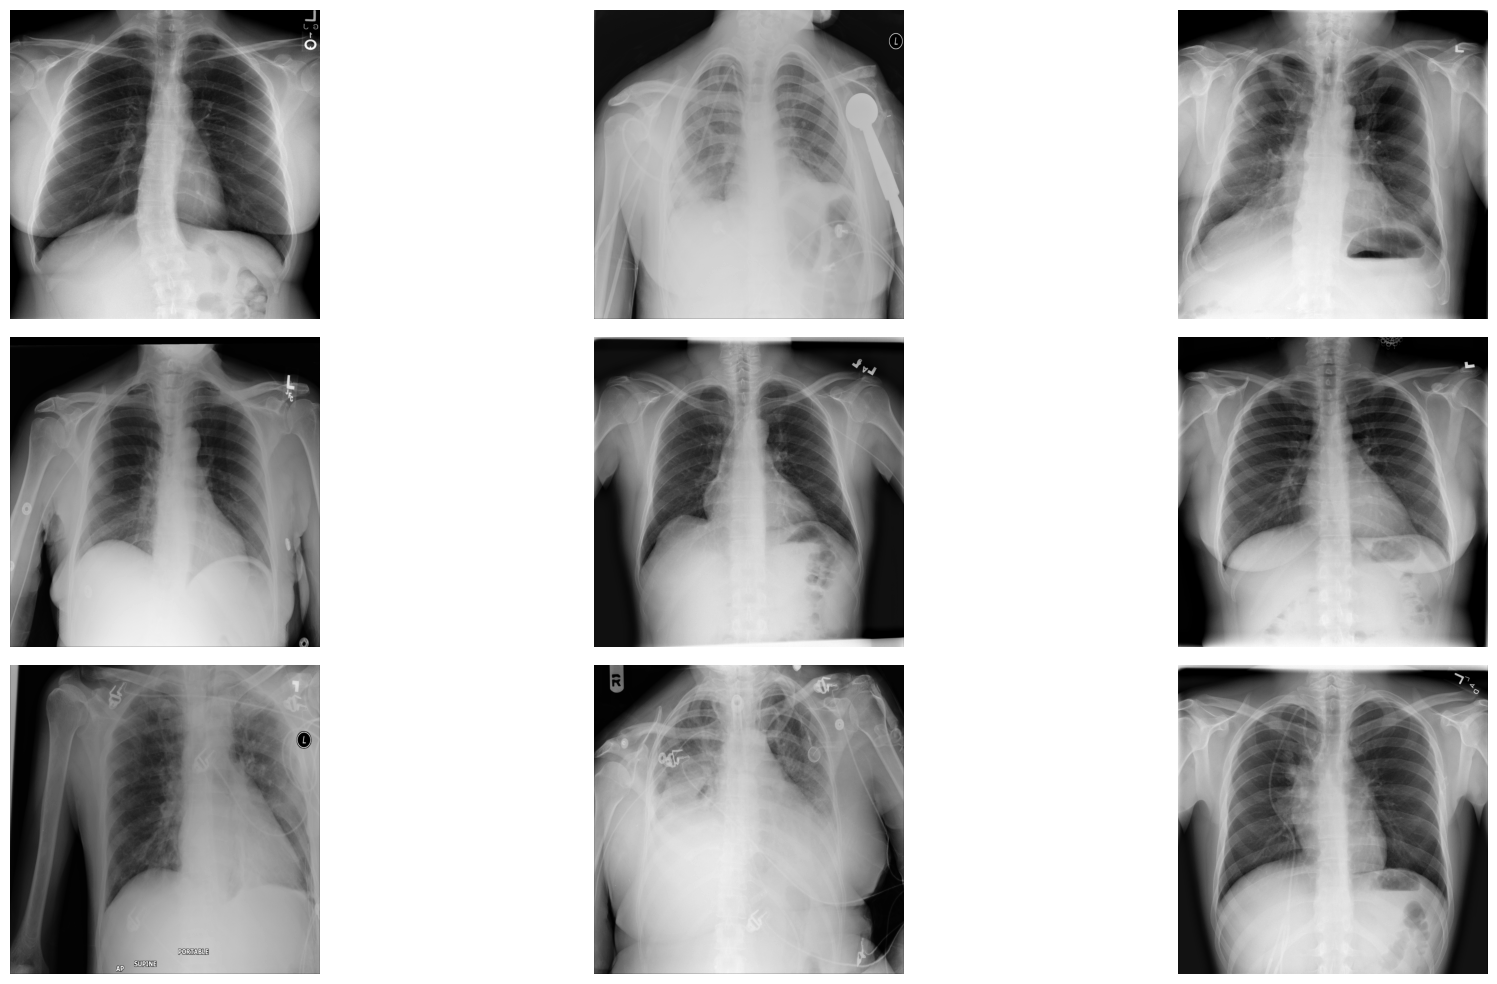

In [21]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'C:\\Users\\sangeetha\\rrg\\images'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


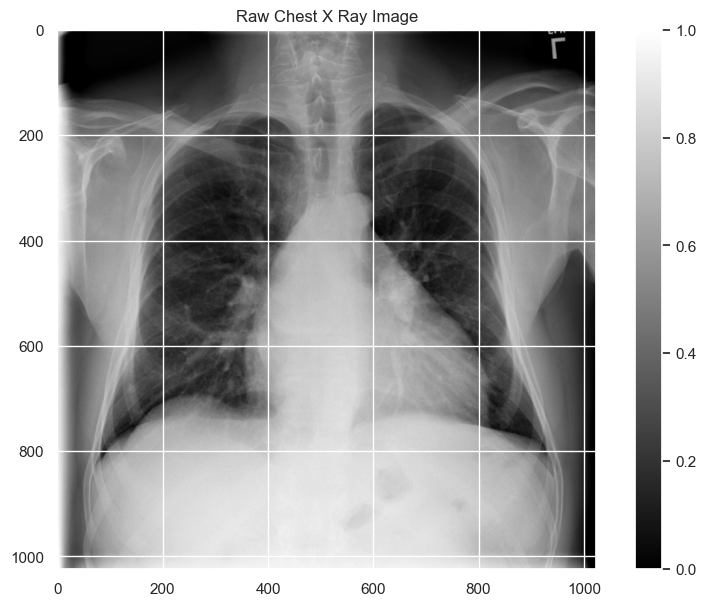

In [22]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

In [23]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation
    
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [25]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.__next__() # generate a batch of samples and associated labels 
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [26]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "C:\\Users\\sangeetha\\rrg\\images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 78566 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 78566 validated image filenames.

getting valid generator...
Found 17063 validated image filenames.

getting test generator...
Found 16491 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.4706 and the minimum is -3.1059
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


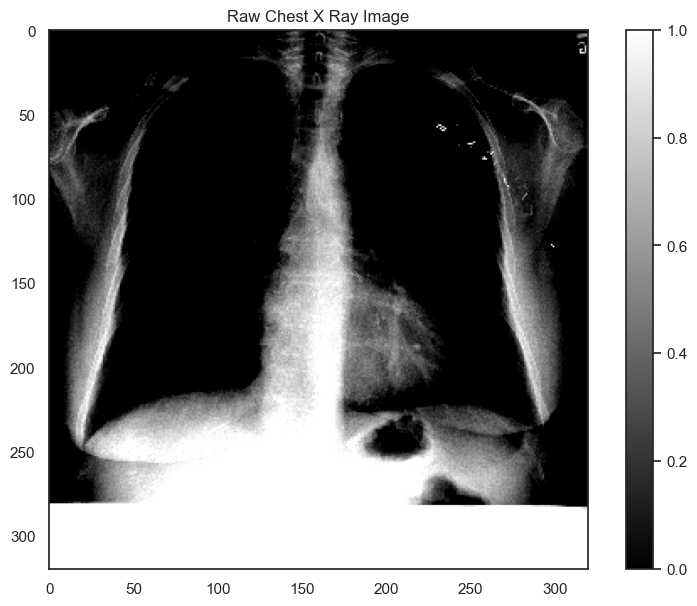

In [27]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [29]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [30]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02403075, 0.0212051 , 0.12006466, 0.00201105, 0.17627218,
       0.05395464, 0.05632207, 0.10405264, 0.04795968, 0.03028027,
       0.01191355, 0.01471374, 0.02074689, 0.04108648])

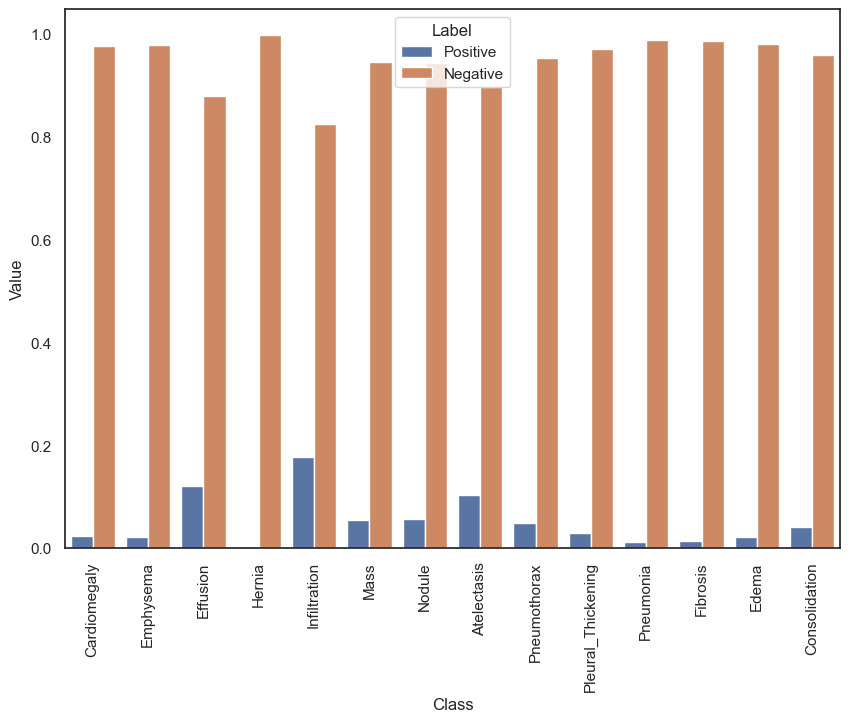

In [31]:
import pandas as pd
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat(
    [data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])],
    ignore_index=True
)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [32]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

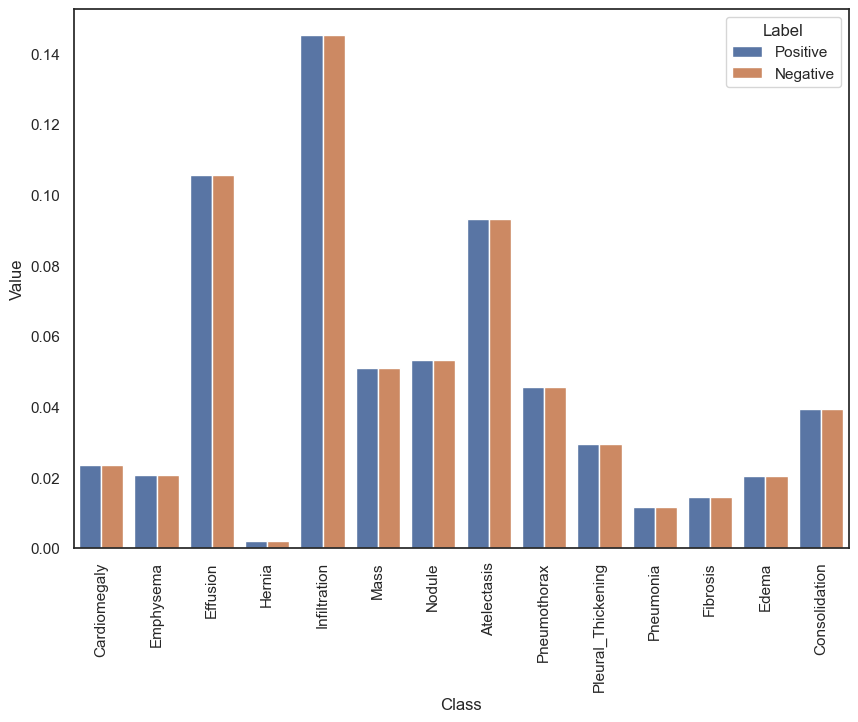

In [33]:
# Create the initial DataFrame
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Convert the list of dictionaries to a DataFrame and append
negative_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} 
                              for l, v in enumerate(neg_contribution)])
data = pd.concat([data, negative_data], ignore_index=True)

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [34]:
import tensorflow as tf

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * tf.reduce_mean(y_true[:, i] * tf.math.log(y_pred[:, i] + epsilon)) \
                    - neg_weights[i] * tf.reduce_mean((1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + epsilon))
        return loss
    
    return weighted_loss


In [100]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights=None, include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("C:\\Users\\sangeetha\\rrg\\pretrained_model.h5")
    print("Loaded Weights")
    return model

In [102]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, None, None, 64)    │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, None, None, 64)    │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 128)   │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 128)   │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 128)   │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 32)    │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, None, None, 96)    │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [41]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=200, 
                              validation_steps=50, 
                              epochs = 5)


Epoch 1/5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 2614s 12s/step - loss: 0.7552 - val_loss: 2.7995
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 39631s 199s/step - loss: 0.7222 - val_loss: 0.9162
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2311s 12s/step - loss: 0.7579 - val_loss: 0.6192
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 3352s 17s/step - loss: 0.7592 - val_loss: 0.8666
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2490s 12s/step - loss: 0.6913 - val_loss: 0.7344


In [42]:
model.save("C:\\Users\\sangeetha\\rrg\\functional_1.h5")

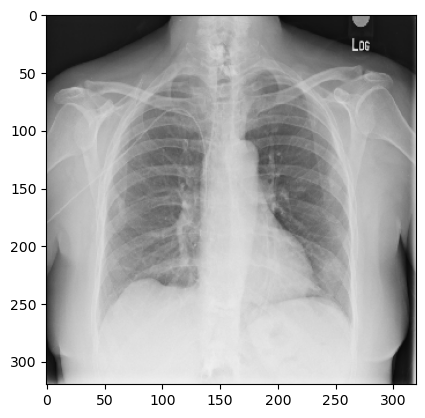

In [67]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR +"\\"+ img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR +"\\"+ '00007009_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [68]:
mean, std = get_mean_std_per_batch(train_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


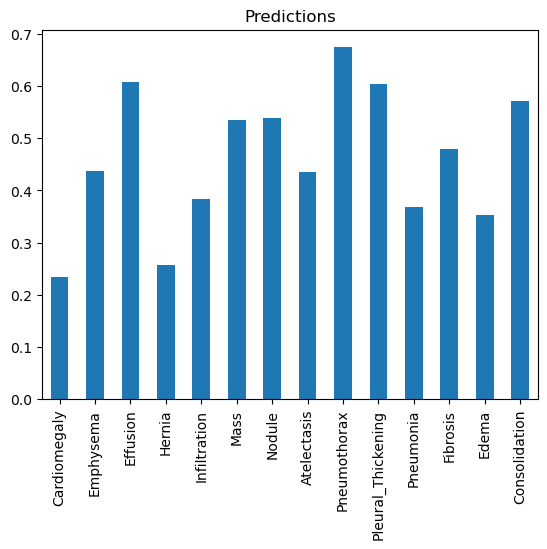

In [69]:

labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [70]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.233988,0.436205,0.60704,0.257161,0.384275,0.535643,0.538167,0.434325,0.674354,0.603244,0.367394,0.478901,0.35246,0.570881


In [71]:
model.save("C:\\Users\\sangeetha\\rrg\\model1.h5")

In [76]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.233988,0.436205,0.60704,0.257161,0.384275,0.535643,0.538167,0.434325,0.674354,0.603244,0.367394,0.478901,0.35246,0.570881


In [92]:
# Load the model with the custom loss function
model = load_model('C:\\Users\\sangeetha\\rrg\\modelrrg.keras', custom_objects={'weighted_loss': weighted_loss})

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 366 variables whereas the saved optimizer has 730 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


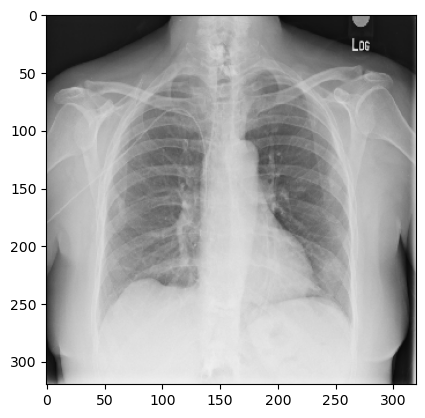

In [93]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR +"\\"+ img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR +"\\"+ '00007009_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [94]:
mean, std = get_mean_std_per_batch(train_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


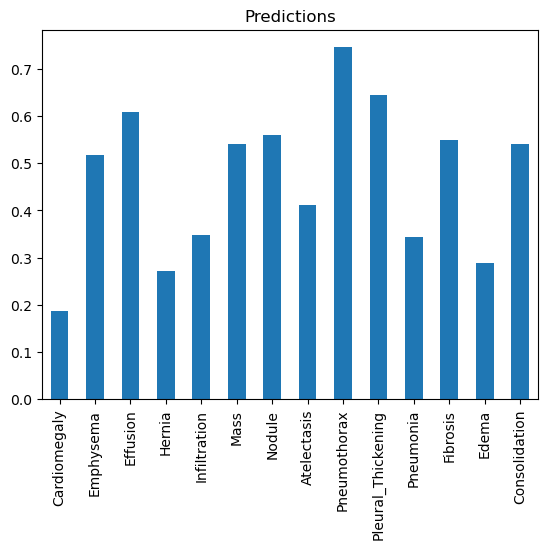

In [97]:
  
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [96]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.186976,0.518014,0.60867,0.272439,0.347032,0.541303,0.559737,0.411937,0.745957,0.644997,0.34459,0.548801,0.289576,0.540146


In [ ]:
model1=model.save("C:\\Users\\sangeetha\\rrg\\modelrrg1.keras")

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define the custom loss function
def weighted_loss(y_true, y_pred):
    # Custom loss function logic here
    # This is an example. Replace with your own logic.
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model with the custom loss function
model1 = load_model('C:\\Users\\sangeetha\\rrg\\modelrrg1.keras', custom_objects={'weighted_loss': weighted_loss})

# Check the summary of the loaded model
model.summary()


In [103]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=50, 
                              epochs = 1)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2296s 17s/step - loss: 0.6985 - val_loss: 1.0786


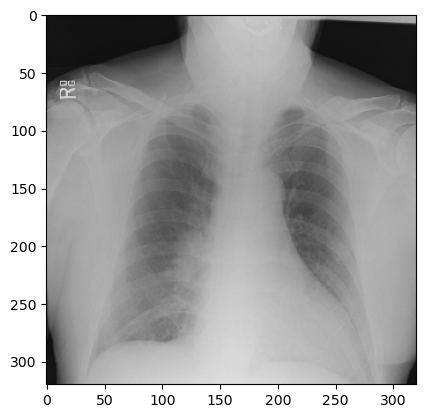

In [108]:
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR +"\\"+ img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR +"\\"+ '00007010_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [109]:
mean, std = get_mean_std_per_batch(train_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


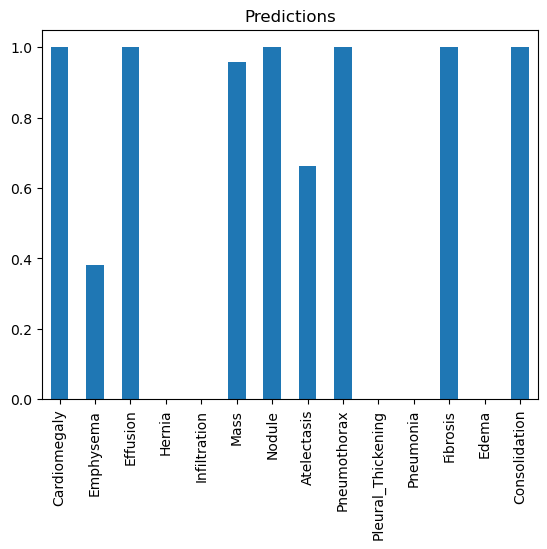

In [110]:
  
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [111]:
pred_df


,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.999926,0.382135,0.999978,3.970504e-11,0.000029,0.957679,0.999883,0.66132,0.999836,2.182909e-08,1.479432e-09,0.999661,1.799115e-07,0.999866
